In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import matplotlib as mpl
from keras.preprocessing import image
from PIL import Image
from IPython.display import display

In [2]:
model = tf.keras.models.load_model('/content/model22.h5')

In [3]:

img_path = '/content/_118.jpg'
img_size = (128, 128)
img = image.load_img(img_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
processed_img = img_array / 255.0

1/1 [==============================] - 2s 2s/step


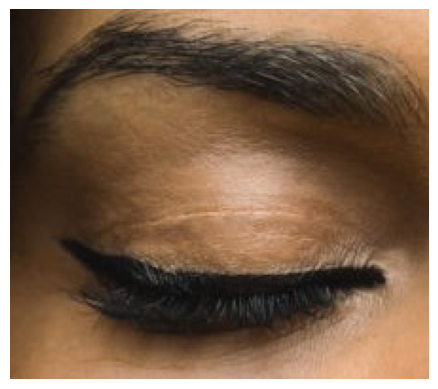

The person is closing his eyes


In [4]:
predictions = model.predict(processed_img)
predicted_label = np.argmax(predictions, axis=-1)[0]
plt.imshow(Image.open(img_path))
plt.axis('off')
plt.show()
if predicted_label == 0:
    print("The person is opening his eyes")
else:
    print("The person is closing his eyes")


In [5]:
last_conv_layer_name = "conv2d_3"

In [12]:

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


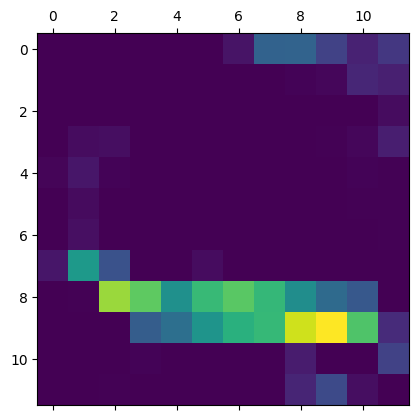

In [13]:
model.layers[-1].activation = None
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=1)
plt.matshow(heatmap)
plt.show()


In [14]:
def save_and_display_gradcam(img_path, heatmap, cam_path="/content/cam.jpg", alpha=0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image.open(cam_path))


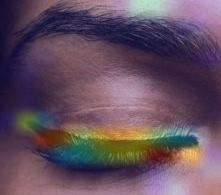

In [15]:
save_and_display_gradcam(img_path, heatmap)
